In [1]:
import requests 
import finnhub
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import sys, os
sys.path.append(os.path.abspath('../'))
import config

# get your api key from https://finnhub.io
finnhub_client =finnhub.Client(api_key=config.FH_API_KEY)

# 1. Quote proba score from model using CURL and python-requests

In [60]:
!curl http://104.154.169.240:5000/news --data "news=Oil Tumbles on Prospect Iranian Nuclear Deal May Be Within Sight" -X POST

0.374896156790326


[how to turn curl command in linux to requests in python](https://flask-restful.readthedocs.io/en/latest/quickstart.html): see Resourceful Routing section



In [61]:
news_item = 'Oil Tumbles on Prospect Iranian Nuclear Deal May Be Within Sight'
host = "http://104.154.169.240:5000"
response = requests.post(host+"/news", data={"news":news_item})
resulting_proba = response.json()
print(resulting_proba)

0.374896156790326


# 2. Download recent Dataset from Finnhub and yFinance

## 2.1. HAS and WMT

- top movers based on https://markets.businessinsider.com/index/market-movers/s&p_500 accessed on Feb-17


### 2.1.1. finnhub for news
    - note that only 8 days data available

In [ ]:
# !pip install finnhub-python 
# note that jupyter notebook is taking the environment outside the venv, plz install the package there as well.

In [4]:
symbol=["WMT","HAS"] 


for name in symbol: 
    print(name)
    lst = finnhub_client.company_news(name, _from="2021-02-09", to="2022-02-17")
    df = pd.DataFrame.from_dict(lst)
    df.to_csv (name+'.csv', index = False, header=True)

WMT
HAS


In [5]:
from datetime import datetime, timedelta

def ut2dt(timestamp):
    dt_object = datetime.fromtimestamp(timestamp)
    return dt_object
timestamp = 1628064660

print(ut2dt(timestamp))
print(type(ut2dt(timestamp)))

#df['Date'] = df['datetime'].map(ut2dt).dt.date
#df['datetime_dt'] = pd.to_datetime(df['datetime'].map(ut2dt))

#df['Time']=df['datetime'].map(ut2dt).dt.time


2021-08-04 04:11:00
<class 'datetime.datetime'>


In [6]:
WMT_news = pd.read_csv("WMT.csv")
WMT_news['datetime_dt'] = pd.to_datetime(WMT_news['datetime'].map(ut2dt))
WMT_news['date'] = WMT_news['datetime_dt'].dt.date
#WMT_news[['date',"headline"]]
df_wmt = WMT_news[['date',"headline"]].set_index('date')
full_list_WMT = list(df_wmt.headline)


In [7]:
HAS_news = pd.read_csv("HAS.csv")
HAS_news['datetime_dt'] = pd.to_datetime(HAS_news['datetime'].map(ut2dt))
HAS_news['date'] = HAS_news['datetime_dt'].dt.date
df_has = HAS_news[['date',"headline"]].set_index('date')
full_list_HAS = list(df_has.headline)

### 2.1.2. yfinance for price

In [8]:
#generate apple's stock adj closing value from yahoo finance
start = datetime(2022,1,10)
##end = datetime(end.year, end.month, end.day)
end = datetime(2022,2,18)

closing_df_WMT = yf.download('WMT', start = start, end=end)['Adj Close']

closing_df_HAS = yf.download('HAS', start = start, end=end)['Adj Close']

walmart_price = closing_df_WMT.to_frame(name='WMT')
hesbro_price = closing_df_HAS.to_frame(name='HAS')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 2.2. WMT labeling: next day's price_change >3%?

In [9]:
walmart_price["sf1"] = walmart_price.WMT.shift(1)
walmart_price["price_change"] = (walmart_price.WMT - walmart_price.sf1)/(walmart_price.sf1)*100
walmart_price["label"] = (abs(walmart_price["price_change"])>3).astype(int)
walmart_price[walmart_price.label==1]


,WMT,sf1,price_change,label
Date,,,,
2022-02-17,138.880005,133.529999,4.006595,1


In [10]:
true_list_WMT = list(df_wmt[(pd.to_datetime(df_wmt.index)=="2022-02-16")].headline)
false_list_WMT = full_list_WMT[:]
for ii in true_list_WMT:
    false_list_WMT.remove(ii)

In [11]:
print(f"Number of headlines in true_list_WMT:{len(true_list_WMT)}")
print(f"Number of headlines in false_list_WMT:{len(false_list_WMT)}")
print(f"Number of headlines in full_list_WMT:{len(full_list_WMT)}")

Number of headlines in true_list_WMT:13
Number of headlines in false_list_WMT:212
Number of headlines in full_list_WMT:225


In [12]:
false_news_label_proba_wmt = []
for news_item in false_list_WMT:
    response = requests.post(host+"/news", data={"news":news_item})
    resulting_proba = response.json()
    false_news_label_proba_wmt.append(resulting_proba)

true_news_label_proba_wmt = []
for news_item in true_list_WMT:
    response = requests.post(host+"/news", data={"news":news_item})
    resulting_proba = response.json()
    true_news_label_proba_wmt.append(resulting_proba)

true_news_label_proba_wmt


[0.3257279087812173,
 0.34202927059010546,
 0.27456145961445166,
 0.8914340048657883,
 0.4536211514903092,
 0.47172106099212563,
 0.670904295674865,
 0.4484925843659185,
 0.19667694990603293,
 0.3029083939241036,
 0.49484068872436554,
 0.6102268695736948,
 0.22434607851332908]

(array([2., 3., 1., 3., 1., 1., 1., 0., 0., 1.]),
 array([0.19667695, 0.26615266, 0.33562836, 0.40510407, 0.47457977,
        0.54405548, 0.61353118, 0.68300689, 0.75248259, 0.8219583 ,
        0.891434  ]),
 <BarContainer object of 10 artists>)

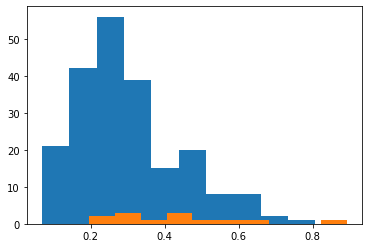

In [13]:
plt.hist(false_news_label_proba_wmt)
plt.hist(true_news_label_proba_wmt)

In [14]:
true_pos_index_wmt = [ii for ii in range(len(true_news_label_proba_wmt)) if true_news_label_proba_wmt[ii]>0.5]
false_neg_index_wmt = [ii for ii in range(len(false_news_label_proba_wmt)) if false_news_label_proba_wmt[ii]<0.5]

true_neg_index_wmt = [ii for ii in range(len(true_news_label_proba_wmt)) if true_news_label_proba_wmt[ii]<0.5]
false_pos_index_wmt = [ii for ii in range(len(false_news_label_proba_wmt)) if false_news_label_proba_wmt[ii]>0.5]


In [15]:
true_pos_headline_samples = [true_list_WMT[jj] for jj in true_pos_index_wmt[:5]]
(true_pos_headline_samples)


['Pre-Market Earnings Report for February 17, 2022 : WMT, SO, BAX, WST, PLTR, EPAM, POOL, GPC, NICE, LKQ, RS, RGEN',
 'Walmart Earnings Report Will Be “The Barometer” Of Consumer Spending',
 'JPMorgan Opens A Lounge In Decentraland, Sees $1 Trillion Metaverse Opportunity']

In [16]:
false_pos_headline_samples = [false_list_WMT[jj] for jj in false_pos_index_wmt[:5]]
(false_pos_headline_samples)


['Walmart Inc. (WMT) CEO Doug McMillon on Q4 2022 Results - Earnings Call Transcript',
 "What's Going on With Fastly? Why Is FSLY Stock Dropping Today?",
 'Snap Out Of It - Thursday, Feb. 17',
 'Pre-Market Most Active for Feb 17, 2022 : PLTR, MRIN, ERIC, TQQQ, SQQQ, NVDA, RBLX, QQQ, FSLY, WMT, CND, BKKT',
 'Walmart : Unit count information as of February 17, 2022']

In [17]:
true_neg_headline_samples = [true_list_WMT[jj] for jj in true_neg_index_wmt[:5]]
(true_neg_headline_samples)

['Walmart Stock To Trade Higher Post Q4?',
 'Walmart Among 14 Companies To Announce Annual Dividend Increase In Late February',
 "Walmart's Mexico unit sees net income rise 5%, even as costs increase",
 'Wall Street eyes Walmart results for signs of tighter margins, slower growth',
 'Is a Surprise Coming for Walmart (WMT) This Earnings Season?']

In [18]:
false_neg_headline_samples = [false_list_WMT[jj] for jj in false_neg_index_wmt[:5]]
(false_neg_headline_samples)


['VYM: Vulnerable To Cyclical Risks',
 'What Walmart’s Solid Earnings Mean for Target and Other Retail Stocks',
 'Walmart Rises Most Since 2020 on Upbeat Outlook, Earnings Beat',
 'WMT Stock: Walmart Earnings Top, Discount Giant Upbeat On Sales, Focuses On Value',
 'Walmart’s advertising business soars 130% to reach $2.1 billion']

## 2.2. HAS labeling: next day's price_change >3%?

In [19]:
hesbro_price["sf1"] = hesbro_price.HAS.shift(1)
hesbro_price["price_change"] = (hesbro_price.HAS - hesbro_price.sf1)/(hesbro_price.sf1)*100
hesbro_price["label"] = (abs(hesbro_price["price_change"])>3).astype(int)
hesbro_price[hesbro_price.label==1]

,HAS,sf1,price_change,label
Date,,,,
2022-01-26,89.111366,94.857605,-6.057752,1
2022-01-31,92.480003,89.290001,3.572631,1
2022-02-09,96.230003,92.290001,4.269154,1


In [20]:
true_list_HAS = list(df_has[(pd.to_datetime(df_has.index)=="2022-01-25")|
       (pd.to_datetime(df_has.index)=="2022-01-28")| # monday price is refered to friday's news
       (pd.to_datetime(df_has.index)=="2022-02-08")].headline)

In [21]:
false_list_HAS = full_list_HAS[:]
for ii in true_list_HAS:
    false_list_HAS.remove(ii)


In [22]:
len(false_list_HAS)

179

In [23]:
len(true_list_HAS)

13

In [24]:
len(full_list_HAS)

192

In [25]:
len(set(true_list_HAS).intersection(set(false_list_HAS)))

0

In [26]:
false_news_label_proba_has = []
for news_item in false_list_HAS:
    response = requests.post(host+"/news", data={"news":news_item})
    resulting_proba = response.json()
    false_news_label_proba_has.append(resulting_proba)

true_news_label_proba_has = []
for news_item in true_list_HAS:
    response = requests.post(host+"/news", data={"news":news_item})
    resulting_proba = response.json()
    true_news_label_proba_has.append(resulting_proba)

true_news_label_proba_has

[0.1240313878614279,
 0.45103053588420694,
 0.4913681917997935,
 0.3887073308771139,
 0.6400015453706392,
 0.19702788966659843,
 0.2741319279061157,
 0.41226961805944323,
 0.15599161182848276,
 0.2318668060510796,
 0.44967021235511406,
 0.23352915075992728,
 0.2224538229652449]

(array([2., 2., 3., 0., 0., 2., 2., 1., 0., 1.]),
 array([0.12403139, 0.1756284 , 0.22722542, 0.27882244, 0.33041945,
        0.38201647, 0.43361348, 0.4852105 , 0.53680751, 0.58840453,
        0.64000155]),
 <BarContainer object of 10 artists>)

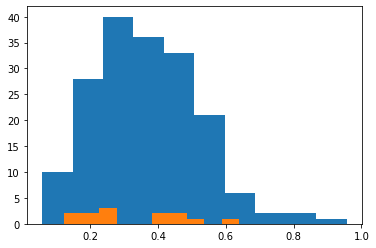

In [28]:

plt.hist(false_news_label_proba_has)
plt.hist(true_news_label_proba_has)

In [35]:
# using 0.5 as threshold

true_pos_index = [ii for ii in range(len(true_news_label_proba_has)) if true_news_label_proba_has[ii]>0.5]
false_neg_index = [ii for ii in range(len(false_news_label_proba_has)) if false_news_label_proba_has[ii]<0.5]

true_neg_index = [ii for ii in range(len(true_news_label_proba_has)) if true_news_label_proba_has[ii]<0.5]
false_pos_index = [ii for ii in range(len(false_news_label_proba_has)) if false_news_label_proba_has[ii]>0.5]

#[false_news_label_proba[ii] for ii in range(len(false_news_label_proba)) if false_news_label_proba[ii]>0.35]

In [37]:
true_neg_headline_samples = [true_list_HAS[jj] for jj in true_neg_index[:5]]
(true_neg_headline_samples)

['A Trio of Stocks With High Returns on Equity',
 'Hasbro Inc. stock falls Tuesday, underperforms market',
 'Leggett (LEG) Q4 Earnings Top, Margins Fall on Economic Woes',
 'Hasbro price target lowered to $121 from $138 at DA Davidson',
 "Netflix to produce Mattel's 'Masters of the Universe' movie"]

In [38]:
true_pos_headline_samples = [true_list_HAS[jj] for jj in true_pos_index[:5]]
true_pos_headline_samples

['Q4 2021 Retail Preview: Supply Chain Problems Continue']

In [39]:

false_neg_headline_samples = [false_list_HAS[jj] for jj in false_neg_index[:5]]
false_neg_headline_samples

['Should You Follow This Activist Investor and Buy Hasbro Stock?',
 "Hasbro Stock Leaps As Activists Push For 'Wizards of the Coast', Spin-off, Board Changes",
 'Why Hasbro Stock Was Surging Higher Today',
 "Hasbro's (NASDAQ:HAS) Upcoming Dividend Will Be Larger Than Last Year's",
 'Hasbro Announces Innovative Play and Entertainment Lineup For 2022']

In [40]:
false_pos_headline_samples = [false_list_HAS[jj] for jj in false_pos_index[:5]]
false_pos_headline_samples

['S&P 500 Movers: VIAC, HAS',
 'Early notable gainers among liquid option names on February 17th',
 'Hasbro Activist Begins Proxy Fight, Urges Wizards Unit Spinoff',
 "Do Hasbro's (NASDAQ:HAS) Earnings Warrant Your Attention?",
 "Mohawk's (MHK) Q4 Earnings and Sales Beat, Q1 View Tepid"]

# Demo

In [52]:
def print_proba_headline_df(sample):
    df = pd.DataFrame()
    proba_list = []
    for news_item in sample:
        
        response = requests.post(host+"/news", data={"news":news_item})
        resulting_proba = response.json()
        proba_list.append(resulting_proba)
    df['proba'] = proba_list
    df['headline'] = sample
    print(df)

For demo purpose:

- True pos  = WMT(first 3)+HAS(first 1)
- False pos = WMT(first 3)+HAS(first 2)
- False neg = WMT(first 3)+HAS(first 2)
- True neg  = WMT(first 3)+HAS(first 2)

In [54]:
TP_sample = [true_list_WMT[jj] for jj in true_pos_index_wmt[:5]]+[true_list_HAS[jj] for jj in true_pos_index[:5]]
TP_sample

['Pre-Market Earnings Report for February 17, 2022 : WMT, SO, BAX, WST, PLTR, EPAM, POOL, GPC, NICE, LKQ, RS, RGEN',
 'Walmart Earnings Report Will Be “The Barometer” Of Consumer Spending',
 'JPMorgan Opens A Lounge In Decentraland, Sees $1 Trillion Metaverse Opportunity',
 'Q4 2021 Retail Preview: Supply Chain Problems Continue']

In [62]:
print_proba_headline_df(TP_sample)

      proba                                           headline
0  0.891434  Pre-Market Earnings Report for February 17, 20...
1  0.670904  Walmart Earnings Report Will Be “The Barometer...
2  0.610227  JPMorgan Opens A Lounge In Decentraland, Sees ...
3  0.640002  Q4 2021 Retail Preview: Supply Chain Problems ...


In [44]:
FP_sample = [false_list_WMT[jj] for jj in false_pos_index_wmt[:3]] + [false_list_HAS[jj] for jj in false_pos_index[:2]]
FP_sample

['Walmart Inc. (WMT) CEO Doug McMillon on Q4 2022 Results - Earnings Call Transcript',
 "What's Going on With Fastly? Why Is FSLY Stock Dropping Today?",
 'Snap Out Of It - Thursday, Feb. 17',
 'S&P 500 Movers: VIAC, HAS',
 'Early notable gainers among liquid option names on February 17th']

In [63]:
print_proba_headline_df(FP_sample)

      proba                                           headline
0  0.583030  Walmart Inc. (WMT) CEO Doug McMillon on Q4 202...
1  0.624170  What's Going on With Fastly? Why Is FSLY Stock...
2  0.527084                 Snap Out Of It - Thursday, Feb. 17
3  0.761817                          S&P 500 Movers: VIAC, HAS
4  0.536449  Early notable gainers among liquid option name...


In [57]:
FN_sample = [false_list_WMT[jj] for jj in false_neg_index_wmt[:3]] + [false_list_HAS[jj] for jj in false_neg_index[:2]]
FN_sample

['VYM: Vulnerable To Cyclical Risks',
 'What Walmart’s Solid Earnings Mean for Target and Other Retail Stocks',
 'Walmart Rises Most Since 2020 on Upbeat Outlook, Earnings Beat',
 'Should You Follow This Activist Investor and Buy Hasbro Stock?',
 "Hasbro Stock Leaps As Activists Push For 'Wizards of the Coast', Spin-off, Board Changes"]

In [64]:
print_proba_headline_df(FN_sample)

      proba                                           headline
0  0.194090                  VYM: Vulnerable To Cyclical Risks
1  0.242304  What Walmart’s Solid Earnings Mean for Target ...
2  0.221643  Walmart Rises Most Since 2020 on Upbeat Outloo...
3  0.249683  Should You Follow This Activist Investor and B...
4  0.344380  Hasbro Stock Leaps As Activists Push For 'Wiza...


In [48]:
TN_sample = [true_list_WMT[jj] for jj in true_neg_index_wmt[:3]] + [true_list_HAS[jj] for jj in true_neg_index[:2]]
TN_sample

['Walmart Stock To Trade Higher Post Q4?',
 'Walmart Among 14 Companies To Announce Annual Dividend Increase In Late February',
 "Walmart's Mexico unit sees net income rise 5%, even as costs increase",
 'A Trio of Stocks With High Returns on Equity',
 'Hasbro Inc. stock falls Tuesday, underperforms market']

In [65]:
print_proba_headline_df(TN_sample)

      proba                                           headline
0  0.325728             Walmart Stock To Trade Higher Post Q4?
1  0.342029  Walmart Among 14 Companies To Announce Annual ...
2  0.274561  Walmart's Mexico unit sees net income rise 5%,...
3  0.124031       A Trio of Stocks With High Returns on Equity
4  0.451031  Hasbro Inc. stock falls Tuesday, underperforms...
